In [13]:
#!g1.1
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-32GB


## Dataset

In [ ]:
#!g1.1

Анализируем некорректные высказывания

In [14]:
#!g1.1
import pandas as pd

In [15]:
#!g1.1

train_df = pd.read_csv('../data/inappropriate/train.csv')
test_df = pd.read_csv('../data/inappropriate/test.csv')

In [337]:
#!g1.1
train_df.shape, test_df.shape

((130665, 21), (16334, 22))

In [17]:
#!g1.1
train_df.head()

,text,inappropriate,offline_crime,online_crime,drugs,gambling,pornography,prostitution,slavery,suicide,...,weapons,body_shaming,health_shaming,politics,racism,religion,sexual_minorities,sexism,social_injustice,human_labeled
0,я думал что левиафаны - это те медленные страх...,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,"А был бы этот полицейский в Петербурге, так пе...",0.95,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,"Напоминаю, что пора искать актис невзрослого п...",1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,курю лет пятнадцать никаких проблем кроме како...,1.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,"окей, я тогда проведу парад гетеросексуалов, п...",1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [18]:
#!g1.1

(train_df.inappropriate > 0.5).astype('int').value_counts()

0    91803
1    38862
Name: inappropriate, dtype: int64

In [19]:
#!g1.1

# statistics of text length (in words)
train_df['text'].apply(lambda s: len(s.split())).describe()

count    130665.000000
mean         16.149834
std          11.963462
min           1.000000
25%           9.000000
50%          13.000000
75%          21.000000
max         738.000000
Name: text, dtype: float64

In [20]:
#!g1.1
train_df['text'].apply(lambda s: len(s.split())).quantile(0.99)

42.0



Let's extract the sentences and labels of our training set as numpy ndarrays.

In [21]:
#!g1.1
# Get the lists of sentences and their labels.
sentences = train_df.text.values
labels = (train_df.inappropriate > 0.5).astype('int').values

#valid_df

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

## 3.1. BERT Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [ ]:
На этот раз, используем русскоязычный Берт от Дип Павлова

In [22]:
#!g1.1
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', do_lower_case=True)

Loading BERT tokenizer...






In [273]:
#!g1.1

# сравним с мультиязычной моделью
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('Geotrend/bert-base-ru-cased', do_lower_case=True)  #мультиязычная, но только с русским словарем

Loading BERT tokenizer...





Let's apply the tokenizer to one sentence just to see the output.


In [307]:
#!g1.1
# Print the original sentence.
print(' Original: ', sentences[1000])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[1000]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[1000])))

 Original:  Я уже написал как я понимаю принцип око за око. Соотносится ли он с заповедями какой либо религии мне все равно. Я не верю ни в одну существующую религию ибо они все лгут и преследуют свои цели)
Tokenized:  ['я', 'уже', 'написал', 'как', 'я', 'понимаю', 'принцип', 'око', 'за', 'око', '.', 'соотносится', 'ли', 'он', 'с', 'заповед', '##ями', 'как', '##ои', 'либо', 'религии', 'мне', 'все', 'равно', '.', 'я', 'не', 'верю', 'ни', 'в', 'одну', 'существующую', 'религию', 'ибо', 'они', 'все', 'л', '##гут', 'и', 'преследуют', 'свои', 'цели', ')']
Token IDs:  [877, 4745, 12715, 2739, 877, 65339, 12058, 19304, 1758, 19304, 132, 105013, 11089, 2886, 869, 19517, 8037, 2739, 15484, 8568, 23539, 16740, 4752, 17561, 132, 877, 1699, 77523, 7036, 845, 12742, 87631, 54405, 32971, 4725, 4752, 863, 46269, 851, 62784, 8305, 16934, 122]


In [ ]:
#!g1.1
сравним 

In [276]:
#!g1.1
# Print the original sentence.
print(' Original: ', sentences[1000])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[1000]))

# Print the sentence mapped to token ids.и
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[1000])))

 Original:  Я уже написал как я понимаю принцип око за око. Соотносится ли он с заповедями какой либо религии мне все равно. Я не верю ни в одну существующую религию ибо они все лгут и преследуют свои цели)
Tokenized:  ['я', 'уже', 'написал', 'как', 'я', 'по', '##нима', '##ю', 'принцип', 'око', 'за', 'око', '.', 'со', '##от', '##нос', '##ится', 'ли', 'он', 'с', 'за', '##пов', '##ед', '##ями', 'како', '##и', 'либо', 'религии', 'мне', 'все', 'равно', '.', 'я', 'не', 'в', '##ер', '##ю', 'ни', 'в', 'одну', 'су', '##ществ', '##ую', '##щую', 'р', '##ели', '##ги', '##ю', 'и', '##бо', 'они', 'все', 'л', '##гу', '##т', 'и', 'пре', '##след', '##уют', 'свои', 'цели', ')']
Token IDs:  [194, 2177, 6886, 707, 194, 369, 12923, 533, 9679, 2848, 320, 2848, 27, 710, 735, 10908, 6727, 5058, 759, 182, 320, 6527, 4856, 3303, 1419, 288, 3651, 12782, 9527, 1729, 14141, 27, 194, 424, 167, 1178, 533, 2986, 167, 4876, 531, 12362, 1974, 7799, 181, 2766, 1851, 533, 173, 4544, 1887, 1729, 176, 2175, 408, 173, 5859

In [ ]:
#!g1.1
сразу видна разница в токенизации

## 3.3. Tokenize Dataset

The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

Just in case there are some longer test sentences, I'll set the maximum length to 64.


Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [23]:
#!g1.1
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.  # возьмем максимальную длину последовательности
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/jupyter/.local/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  я думал что левиафаны - это те медленные страхоебины с NUMBER вебмки
Token IDs: tensor([  101,   877, 48241,  1997, 10208, 17116, 51988,   880,   130,  3998,
         4922, 62570,  2059, 14626,  2325, 11907,   880,   869, 22948, 12724,
        23663,   866,  2237,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


## 3.4. Training & Validation Split


Divide up our training set to use 90% for training and 10% for validation.

In [24]:
#!g1.1
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

117,598 training samples
13,067 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [25]:
#!g1.1
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 164  # указываем батч-сайз

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

## 4.1. BertForSequenceClassification

OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [26]:
#!g1.1
from transformers import BertForSequenceClassification, AdamW, BertConfig

#НУЖНО УКАЗАТЬ КОЛ-ВО КЛАССОВ
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "DeepPavlov/rubert-base-cased", # Use the 12-layer BERT model, with an uncased vocab.  # Geotrend/bert-base-ru-cased  DeepPavlov/rubert-base-cased
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [27]:
#!g1.1
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

#!g1.1
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

Define a helper function for calculating accuracy.

In [28]:
#!g1.1
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

#!g1.1
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))



Helper function for formatting elapsed times as `hh:mm:ss`


We're ready to kick off the training!

#!g1.1
Как определить оптимальный батч сайз? и MAX_SEQ_LENGTH?
72 и 256?

Кажется, что мы сильно порезали наши данные, оценим качество и перезапустим обучение

In [29]:
#!g1.1
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    718.    Elapsed: 0:00:20.
  Batch    80  of    718.    Elapsed: 0:00:40.
  Batch   120  of    718.    Elapsed: 0:01:00.
  Batch   160  of    718.    Elapsed: 0:01:20.
  Batch   200  of    718.    Elapsed: 0:01:40.
  Batch   240  of    718.    Elapsed: 0:02:00.
  Batch   280  of    718.    Elapsed: 0:02:20.
  Batch   320  of    718.    Elapsed: 0:02:40.
  Batch   360  of    718.    Elapsed: 0:03:00.
  Batch   400  of    718.    Elapsed: 0:03:20.
  Batch   440  of    718.    Elapsed: 0:03:41.
  Batch   480  of    718.    Elapsed: 0:04:01.
  Batch   520  of    718.    Elapsed: 0:04:21.
  Batch   560  of    718.    Elapsed: 0:04:41.
  Batch   600  of    718.    Elapsed: 0:05:01.
  Batch   640  of    718.    Elapsed: 0:05:22.
  Batch   680  of    718.    Elapsed: 0:05:42.

  Average training loss: 0.48
  Training epcoh took: 0:06:01

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.44
  Validation took: 0:00:13

====

Let's view the summary of the training process.

In [30]:
#!g1.1
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.см
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.48,0.44,0.79,0:06:01,0:00:13
2,0.39,0.44,0.80,0:06:04,0:00:13
3,0.33,0.46,0.80,0:06:05,0:00:13


In [31]:
#!g1.1
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.см
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.48,0.44,0.79,0:06:01,0:00:13
2,0.39,0.44,0.80,0:06:04,0:00:13
3,0.33,0.46,0.80,0:06:05,0:00:13


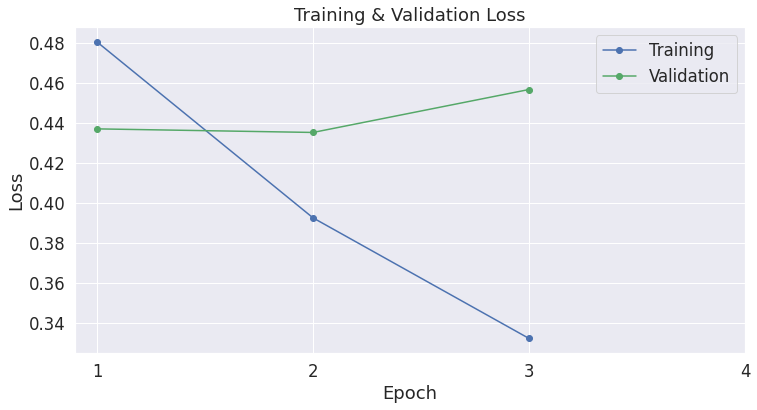

In [32]:
#!g1.1
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
#!g1.1
на 3 эпохе модель начинает переобучаться

In [33]:
#!g1.1

#сохраним веса модели:

torch.save(model.state_dict(), 'ru-inappropriate.bin')

In [ ]:
#!g1.1



#загрузим модель

#model = TheModelClass(args, *kwargs) 
model.load_state_dict(torch.load('ru-inappropriate.bin')) 
model.to(device)

# 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [34]:
#!g1.1
test_df.head(2)

,text,inappropriate,offline_crime,online_crime,drugs,gambling,pornography,prostitution,slavery,suicide,...,weapons,body_shaming,health_shaming,politics,racism,religion,sexual_minorities,sexism,social_injustice,human_labeled
0,"если тупой, то хотя бы проверь, насколько ты у...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,Из за этого началась война между террористоми ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [35]:
#!g1.1

#!g1.1
import pandas as pd

# Load the dataset into a pandas dataframe.

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

# Create sentence and label lists
sentences = test_df.text.values
labels = (test_df.inappropriate > 0.5).astype('int').values


# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.  # max lenght IS SET TO 64!
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 144    #BATCH SIZE!

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 16,334



/home/jupyter/.local/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [36]:
#!g1.1
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 16,334 test sentences...
    DONE.


In [37]:
#!g1.1
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)




In [38]:
#!g1.1

flat_true_labels.shape, flat_predictions.shape

((16334,), (16334,))

In [39]:
#!g1.1
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report


## Результаты обучения на deep pavlov

In [40]:
#!g1.1

#!g1.1
print('accuracy', np.round(accuracy_score(flat_true_labels, flat_predictions),3)) #качество на тесте
print('f1', np.round(f1_score(flat_true_labels, flat_predictions, average='macro'),2)) #качество на тесте
print('roc_auc', np.round(roc_auc_score(flat_true_labels, np.concatenate(predictions, axis=0)[:, 1]),2)) #качество на тесте

accuracy 0.792
f1 0.75
roc_auc 0.85


In [41]:
#!g1.1
#!g1.1
print(classification_report(flat_true_labels, flat_predictions)) #качество на тесте

              precision    recall  f1-score   support

           0       0.84      0.87      0.85     11442
           1       0.67      0.61      0.64      4892

    accuracy                           0.79     16334
   macro avg       0.75      0.74      0.75     16334
weighted avg       0.79      0.79      0.79     16334



## Сравним с результатами мультиязычной модели

In [292]:
#!g1.1
#!g1.1
print('accuracy', np.round(accuracy_score(y_true, flat_predictions),3)) #качество на тесте
print('f1', np.round(f1_score(y_true, flat_predictions, average='macro'),2)) #качество на тесте
print('roc_auc', np.round(roc_auc_score(y_true, np.concatenate(predictions, axis=0)[:, 1]),2)) #качество на тесте

accuracy 0.781
f1 0.72
roc_auc 0.83


In [294]:
#!g1.1
print(classification_report(y_true, flat_predictions)) #качество на тесте


              precision    recall  f1-score   support

           0       0.82      0.88      0.85     11442
           1       0.66      0.55      0.60      4892

    accuracy                           0.78     16334
   macro avg       0.74      0.71      0.72     16334
weighted avg       0.77      0.78      0.77     16334



In [ ]:
## Вывод

мы обучили две модели на одном русскоязычном датасете для бинарной классификации

Мы видим, что моноязычная модель "из коробки" работает чуть лучше, чем мультиязычная модель. 
Насколько важна разница в несколько пунктов - зависит от задачи, тем не менее, стоит так же провести сравнение с моделью с полным мультиязычным словарем и 
сравнить результат 


Предметом нашего исследования является - поиск - есть ли разница в уязвимости моделей для адверсариальных атак в
зависимости от того, модель моно или мультиязычная

## Adversarial

In [43]:
#!g1.1

import textattack
from datasets import Dataset


In [46]:
#!g1.1

model_wrapper = textattack.models.wrappers.HuggingFaceModelWrapper(model, tokenizer)
attack = textattack.attack_recipes.TextFoolerJin2019.build(model_wrapper)

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


In [44]:
#!g1.1
test_df['labels'] = (test_df.inappropriate > 0.5).astype('int').values

dataset = Dataset.from_pandas(test_df.sample(1000)[['text', 'labels']])

dataset = textattack.datasets.HuggingFaceDataset(dataset, dataset_columns = (['text'], 'labels'))


In [45]:
#!g1.1
attack_args = textattack.AttackArgs(num_examples=100, log_to_csv="logRu.csv", checkpoint_interval=20, checkpoint_dir="checkpoints", disable_stdout=True)


In [47]:
#!g1.1
#!g1.1
attacker = textattack.Attacker(attack, dataset, attack_args)


# что на вход можно подавать в качестве аргумента для датасета? туториал подсказывает, что нужно сначала загрузить датасет в библиотеку

In [49]:
#!g1.1
%%time 

attacker.attack_dataset()

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
       

textattack: Logging to CSV at path logRu.csv
[Succeeded / Failed / Skipped / Total] 0 / 1 / 0 / 1:   1%|          | 1/100 [00:00<00:10,  9.38it/s]Using /tmp/tfhub_modules to cache modules.
Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
[Succeeded / Failed / Skipped / Total] 2 / 16 / 2 / 20:  20%|██        | 20/100 [00:24<01:39,  1.25s/it]textattack: Saving checkpoint under "checkpoints/1640759293730.ta.chkpt" at 2021-12-29 06:28:13 after 20 attacks.
[Succeeded / Failed / Skipped / Total] 3 / 29 / 8 / 40:  40%|████      | 40/100 [00:31<00:47,  1.27it/s]textattack: Saving checkpoint under "checkpoints/1640759300213.ta.chkpt" at 2021-12-29 06:28:20 after 40 attacks.
[Succeeded / Failed / Skipped / Total] 5 / 41 / 14 / 60:  60%|██████    | 60/100 [00:36<00:24,  1.64it/s]textattack: Saving checkpoint under "checkpoints/1640759305502.ta.chkpt" at 2021-12-29 06:28:25 after

#!g1.1
## Все вместе:

In [52]:
#!g1.1
attack = BAEGarg2019.build(model_wrapper)
attack_args = textattack.AttackArgs(num_examples=100, log_to_csv="logRuBae.csv", checkpoint_interval=20, checkpoint_dir="checkpoints", disable_stdout=True)
attacker = textattack.Attacker(attack, dataset, attack_args)


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


In [ ]:
#!g1.1


In [54]:
#!g1.1
%%time

#запустим бае на основе мультиязычного берта

attacker.attack_dataset()

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bae
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  50
    (min_confidence):  0.0
  )
  (constraints): 
    (0): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.936338023
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 

















+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 77     |
| Number of failed att

textattack: Logging to CSV at path logRuBae.csv
[Succeeded / Failed / Skipped / Total] 16 / 2 / 2 / 20:  20%|██        | 20/100 [01:00<04:03,  3.05s/it]textattack: Saving checkpoint under "checkpoints/1640759826133.ta.chkpt" at 2021-12-29 06:37:06 after 20 attacks.
[Succeeded / Failed / Skipped / Total] 28 / 4 / 8 / 40:  40%|████      | 40/100 [01:37<02:25,  2.43s/it]textattack: Saving checkpoint under "checkpoints/1640759862481.ta.chkpt" at 2021-12-29 06:37:42 after 40 attacks.
[Succeeded / Failed / Skipped / Total] 41 / 5 / 14 / 60:  60%|██████    | 60/100 [02:10<01:26,  2.17s/it]textattack: Saving checkpoint under "checkpoints/1640759895307.ta.chkpt" at 2021-12-29 06:38:15 after 60 attacks.
[Succeeded / Failed / Skipped / Total] 57 / 6 / 17 / 80:  80%|████████  | 80/100 [02:48<00:42,  2.11s/it]textattack: Saving checkpoint under "checkpoints/1640759934129.ta.chkpt" at 2021-12-29 06:38:54 after 80 attacks.
[Succeeded / Failed / Skipped / Total] 77 / 6 / 17 / 100: 100%|██████████| 100

In [61]:
#!g1.1
#!g1.1
attack = BAEGarg2019Pavlov.build(model_wrapper)
attack_args = textattack.AttackArgs(num_examples=500, log_to_csv="logRuBaePavlov.csv", checkpoint_interval=100, checkpoint_dir="checkpoints", disable_stdout=True)
attacker = textattack.Attacker(attack, dataset, attack_args)


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


In [62]:
#!g1.1
%%time

#запустим бае на основе мультиязычного берта

attacker.attack_dataset()

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bae
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  50
    (min_confidence):  0.0
  )
  (constraints): 
    (0): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.936338023
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 

















+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 358    |
| Number of failed att

textattack: Logging to CSV at path logRuBaePavlov.csv
  0%|          | 0/500 [00:00<?, ?it/s]Using /tmp/tfhub_modules to cache modules.
Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
[Succeeded / Failed / Skipped / Total] 75 / 8 / 17 / 100:  20%|██        | 100/500 [04:19<17:18,  2.60s/it]textattack: Saving checkpoint under "checkpoints/1640769520021.ta.chkpt" at 2021-12-29 09:18:40 after 100 attacks.
[Succeeded / Failed / Skipped / Total] 154 / 13 / 33 / 200:  40%|████      | 200/500 [08:22<12:33,  2.51s/it]textattack: Saving checkpoint under "checkpoints/1640769762404.ta.chkpt" at 2021-12-29 09:22:42 after 200 attacks.
[Succeeded / Failed / Skipped / Total] 220 / 21 / 59 / 300:  60%|██████    | 300/500 [11:50<07:53,  2.37s/it]textattack: Saving checkpoint under "checkpoints/1640769971238.ta.chkpt" at 2021-12-29 09:26:11 after 300 attacks.
[Succeeded / Failed / Ski

In [50]:
#!g1.1

from textattack.constraints.grammaticality import PartOfSpeech
from textattack.constraints.pre_transformation import (
    RepeatModification,
    StopwordModification,
)
from textattack.constraints.semantics.sentence_encoders import UniversalSentenceEncoder
from textattack.goal_functions import UntargetedClassification
from textattack.search_methods import GreedyWordSwapWIR
from textattack.transformations import WordSwapMaskedLM

from textattack.attack_recipes.attack_recipe import AttackRecipe

In [58]:
#!g1.1

class BAEGarg2019Pavlov(AttackRecipe):
    """Siddhant Garg and Goutham Ramakrishnan, 2019.
    BAE: BERT-based Adversarial Examples for Text Classification.
    https://arxiv.org/pdf/2004.01970
    This is "attack mode" 1 from the paper, BAE-R, word replacement.
    We present 4 attack modes for BAE based on the
        R and I operations, where for each token t in S:
        • BAE-R: Replace token t (See Algorithm 1)
        • BAE-I: Insert a token to the left or right of t
        • BAE-R/I: Either replace token t or insert a
        token to the left or right of t
        • BAE-R+I: First replace token t, then insert a
        token to the left or right of t
    """

    @staticmethod
    def build(model_wrapper):
        # "In this paper, we present a simple yet novel technique: BAE (BERT-based
        # Adversarial Examples), which uses a language model (LM) for token
        # replacement to best fit the overall context. We perturb an input sentence
        # by either replacing a token or inserting a new token in the sentence, by
        # means of masking a part of the input and using a LM to fill in the mask."
        #
        # We only consider the top K=50 synonyms from the MLM predictions.
        #
        # [from email correspondance with the author]
        # "When choosing the top-K candidates from the BERT masked LM, we filter out
        # the sub-words and only retain the whole words (by checking if they are
        # present in the GloVE vocabulary)"
        #
        transformation = WordSwapMaskedLM(
            method="bae", masked_language_model="DeepPavlov/rubert-base-cased", max_candidates=50, min_confidence=0.0
        )
        #
        # Don't modify the same word twice or stopwords.
        #
        constraints = [RepeatModification(), StopwordModification()]

        # For the R operations we add an additional check for
        # grammatical correctness of the generated adversarial example by filtering
        # out predicted tokens that do not form the same part of speech (POS) as the
        # original token t_i in the sentence.
        constraints.append(PartOfSpeech(allow_verb_noun_swap=True))

        # "To ensure semantic similarity on introducing perturbations in the input
        # text, we filter the set of top-K masked tokens (K is a pre-defined
        # constant) predicted by BERT-MLM using a Universal Sentence Encoder (USE)
        # (Cer et al., 2018)-based sentence similarity scorer."
        #
        # "[We] set a threshold of 0.8 for the cosine similarity between USE-based
        # embeddings of the adversarial and input text."
        #
        # [from email correspondence with the author]
        # "For a fair comparison of the benefits of using a BERT-MLM in our paper,
        # we retained the majority of TextFooler's specifications. Thus we:
        # 1. Use the USE for comparison within a window of size 15 around the word
        # being replaced/inserted.
        # 2. Set the similarity score threshold to 0.1 for inputs shorter than the
        # window size (this translates roughly to almost always accepting the new text).
        # 3. Perform the USE similarity thresholding of 0.8 with respect to the text
        # just before the replacement/insertion and not the original text (For
        # example: at the 3rd R/I operation, we compute the USE score on a window
        # of size 15 of the text obtained after the first 2 R/I operations and not
        # the original text).
        # ...
        # To address point (3) from above, compare the USE with the original text
        # at each iteration instead of the current one (While doing this change
        # for the R-operation is trivial, doing it for the I-operation with the
        # window based USE comparison might be more involved)."
        #
        # Finally, since the BAE code is based on the TextFooler code, we need to
        # adjust the threshold to account for the missing / pi in the cosine
        # similarity comparison. So the final threshold is 1 - (1 - 0.8) / pi
        # = 1 - (0.2 / pi) = 0.936338023.
        use_constraint = UniversalSentenceEncoder(
            threshold=0.936338023,
            metric="cosine",
            compare_against_original=True,
            window_size=15,
            skip_text_shorter_than_window=True,
        )
        constraints.append(use_constraint)
        #
        # Goal is untargeted classification.
        #
        goal_function = UntargetedClassification(model_wrapper)
        #
        # "We estimate the token importance Ii of each token
        # t_i ∈ S = [t1, . . . , tn], by deleting ti from S and computing the
        # decrease in probability of predicting the correct label y, similar
        # to (Jin et al., 2019).
        #
        # • "If there are multiple tokens can cause C to misclassify S when they
        # replace the mask, we choose the token which makes Sadv most similar to
        # the original S based on the USE score."
        # • "If no token causes misclassification, we choose the perturbation that
        # decreases the prediction probability P(C(Sadv)=y) the most."
        #
        search_method = GreedyWordSwapWIR(wir_method="delete")

        return BAEGarg2019(goal_function, constraints, transformation, search_method)

In [9]:
#!g1.1
be = BAEGarg2019

In [12]:
#!g1.1
be.transformation

AttributeError: type object 'BAEGarg2019' has no attribute 'transformation'

In [ ]:
#!g1.1


In [2]:
#!g1.1
import textattack

textattack.attack_recipes.bae_garg_2019.BAEGarg2019

ImportError: cannot import name 'create_repo' from 'huggingface_hub' (/home/jupyter/.local/lib/python3.7/site-packages/huggingface_hub/__init__.py)

In [336]:
#!g1.1
%%time

#!g1.1
## Попробуем BAE еще раз
#attack_recipes.bae_garg_2019.BAEGarg2019
attack = textattack.attack_recipes.bae_garg_2019.BAEGarg2019.build(model_wrapper)
attack_args = textattack.AttackArgs(num_examples=100, log_to_csv="logRu2.csv", checkpoint_interval=20, checkpoint_dir="checkpoints", disable_stdout=True)
attacker = textattack.Attacker(attack, dataset, attack_args)
attacker.attack_dataset()






Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bae
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  50
    (min_confidence):  0.0
  )
  (constraints): 
    (0): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.936338023
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 

















+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 52     |
| Number of faile

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path logRu2.csv
[Succeeded / Failed / Skipped / Total] 11 / 1 / 8 / 20:  20%|██        

In [ ]:
#!g1.1
с учетом того, что у моделей разные словари - нужно понять, как адаптировать для русского?
посмотреть примеры для других языков из репозитория

In [ ]:
#!g1.1
Пока что видно, что бае справляется - нужно смотреть на примеры